In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import itertools
import time
from google.colab import output
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class GreenHouseEnv(object):
  def __init__(self,m,n,o):  #m, n and o is the dimension of the grid
    #self.grid = np.zeros((m,n))
    self.m = m
    self.n = n
    self.o = o
    self.occupied = []
    self.statePosDict ={}
    self.statePositionDict(m,n,o)
    #self.obsSpace = [[[k for k in range(self.o)] for j in range(self.n)] for i in range(self.m)]
    self.obsSpace = [i for i in range(self.m * self.n * self.o)]
    #print(self.obsSpace)
    self.actSpace = [i for i in range(self.m * self.n * self.o)] #{'U': 0, 'D': 1, 'L': 2, 'R': 3, 'B': 4, 'F': 5}
    self.possibleAct = ['U','D','L','R', 'B', 'F']
    self.addComponents()
    self.rules_arr_rew = [9999,9999,0,0,9999,9999]
    self.env_pos_log = []
    self.rew_vec = [99999,99999,0,0,99999,99999] #6 is number of objectives
    self.log_d = {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.log_best_d =  {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.rew_obtained =  {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.best_pos = [999,999,999]
    self.best_pos_2 = [999,999]
    self.best_pos_3 = [0,0]
    self.best_pos_4 = [0,0]
    self.best_pos_5 = [999,999]
    self.best_pos_6 = [999,999]
    self.best_pos_log_2 =  []
    self.best_pos_log_3 =  []
    self.best_pos_log_4 =  []
    self.best_pos_log_5 =  []
    self.best_pos_log_6 =  []
    self.best_pos_log =  []
    self.prev_distance = [99999,99999,0,0,99999,99999] #to keep record of the prev distance
    self.env_front_1 = []
    self.env_front_2 = []
  
  def addComponents(self):
    self.components = [0,1,2,3,4,5,6,7] #[0,1,2,3,4,5,6,7,8,9]

    if len(self.components)> self.m*self.n*self.o:
      print('errorrrr')
      return 0

    
    self.comp_dictionary = {
        1: 'heater',
        2: 'water tank',
        3: 'pack soil',
        4: 'heat sensor',
        5: 'camera',
        6: 'fan',
        7: 'led',
        8: 'water pump',
        9: 'PCB',
        10: 'Pipes'
    }

    #self.grid = np.zeros((self.m,self.n,self.o))
    #print('grid: 111', self.grid)  
    
    len_com = len(self.components)
    i = 0
    while len_com != 0:
      #print('i',i)
      x = random.choice(range(0,self.m))
      y = random.choice(range(0,self.n))
      z = random.choice(range(0,self.o))
      if (x,y,z) not in self.occupied:
        #self.grid[x,y,z] = components[i]
        self.occupied.append((x,y,z))
        len_com -= 1
        i += 1
      

      #else:
      #  x = random.choice(range(0,self.m))
      #  y = random.choice(range(0,self.n))
      #  z = random.choice(range(0,self.o))
      #  self.grid[x,y,z] = components[i]
      #  self.occupied.append((x,y,z))
    #print('grid: ', np.shape(self.grid))   
    print('occupied:',self.occupied)

  def getComponentPosition(self, index):
    return self.occupied[index]

  def getComponentValue(self, pos):
    if pos in self.occupied:
      id = self.occupied.index(pos)
      val = self.components[id]
    else:
      val = -1
    return val

  def setState(self, state, comp_id):
    x,y,z = self.getComponentPosition(comp_id)
    #self.grid[x,y,z] = -1
    x,y,z = state
    #self.grid[x,y,z] = components[comp_id]
    self.occupied[comp_id] = state

  def calcDistance(self, comp_id_1, comp_id_2):
    x_1, y_1, z_1 = self.getComponentPosition(comp_id_1)
    x_2, y_2, z_2 = self.getComponentPosition(comp_id_2)
    dist = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
    return dist
  
  def totalDistance(self, components):
    total_dist = 0
    for i in range(len(components)):
      for j in range(len(components)):
        i_pos = self.getComponentPosition(i+1)
        j_pos = self.getComponentPosition(j+1)
        dist_temp = self.calcDistance(i_pos, j_pos)
        total_dist += dist_temp

    return total_dist


  def obj1(self):
    #print(self.rules_arr_rew)
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)


    
    #rule 1 - minimize distance between pack soil, water tank and water pump
    #if component == 2 or component == 3 or component == 8:
    #print('RULE 1')
    d1 = self.calcDistance(1,2)
    d2 = self.calcDistance(2,7)
    d3 = self.calcDistance(1,7)
    avg_d = (d1 + d2 + d3)/3
    #print('avg',avg_d)
      
    temp_rew_vec[0] = avg_d

    #find diff from last distance and new distance
    diff_1 = avg_d - self.rew_vec[0]
    diff_2 = self.prev_distance[0] - self.rew_vec[0]

    diff = diff_1 - diff_2

      
    #reward for moving closer or away from the best distance
    if avg_d>self.prev_distance[0]: # move away
      rew_comp[0] = -1
    elif avg_d<self.prev_distance[0]: # move closer
      #if it moves closer then check for the best score
      if avg_d<self.rew_vec[0]: #set a new best score
        rew_comp[0] = 10
        self.rew_vec[0] = avg_d
        pos1 = self.getComponentPosition(1)
        pos2 = self.getComponentPosition(2)
        pos3 = self.getComponentPosition(7)
        self.best_pos = [pos1, pos2, pos3]
        self.best_pos_log.append(self.best_pos)
      elif avg_d==self.rew_vec[0]: #find a similar best score
        rew_comp[0] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[0] = 2
    elif avg_d==self.prev_distance[0]: # stay in same place
      rew_comp[0] = 0.5

        

    #save the new distance as prev distance
    self.prev_distance[0] = avg_d
      
    '''
      if avg_d<self.rew_vec[0]:
        rew_comp[0] = 1
        self.rew_vec[0] = avg_d
        
      elif avg_d>self.rew_vec[0]:
        rew_comp[0] = -20
      else:
        rew_comp[0] = 0
      '''
    self.log_d[0].append(avg_d)
    self.log_best_d[0].append(self.rew_vec[0])
    self.rew_obtained[0].append(rew_comp[0])
    #print('score obtained',rew_comp[0])
    #print('avg_d', avg_d)
    #print('slf.rew_vec', self.rew_vec[0])
    #print('reward',rew_comp[0])
      
      #total += rew1
      #print('#MINIMIZE# old dist: ', self.rules_arr_rew[0], 'new dist:', avg_d ,'rew1:', rew1)
    '''
    #rule 2 - minimize distance between heater and the fan
    if component == 1 or component == 6:
      #print('RULE 2')
      #print(self.rules_arr_rew)
      hf = self.calcDistance(0,5)
      #print('dist',hf)
      
      temp_rew_vec[1] = hf
      if hf<self.rew_vec[1]:
        rew_comp[1] = 1
        
      elif hf > self.rew_vec[1]:
        rew_comp[1] = -1
      else:
        rew_comp[1] = 0
      #print('#MINIMIZE# old dist: ', self.rules_arr_rew[1],'new dist:', hf , 'rew2:', rew2)

    #rule 3 - maximize distance between LED and heat sensor
    if component == 4 or component == 7:
      #print('RULE 3')
      lhs = self.calcDistance(3,6)
      
      temp_rew_vec[2] = lhs
      if lhs>self.rew_vec[2]:
        rew_comp[2] = 1
        
      elif lhs < self.rew_vec[2]:
        rew_comp[2] = -1
      else:
        rew_comp[2] = 0
      
      #print('#MAXIMIZE# old dist: ', self.rules_arr_rew[2],'new dist:', lhs , 'rew3:', rew3)

    #rule 4 - maximize distance between heater and heat sensor
    
    if component == 1 or component == 4:
      #print('RULE 4')
      hhs = self.calcDistance(0,3)
      #print('hhs',hhs,'rules_arr',self.rules_arr_rew[3])
      
      temp_rew_vec[3] = hhs
      if hhs>self.rew_vec[3]:
        rew_comp[3] = 1
        
      elif hhs < self.rew_vec[3]:
        rew_comp[3] = -1
      else:
        rew_comp[3] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[3], 'new dist:', hhs ,'rew4:', rew4)
    
    #rule 5 - maximize lighting of pack soil by the LED
    if component == 7 or component == 3:
      #print('RULE 5')
      x_1, y_1, z_1 = self.getComponentPosition(3)
      z_1 = 0  #z moves to the top of the greenhouse
      x_2, y_2, z_2 = self.getComponentPosition(7)
      psl = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
      
      temp_rew_vec[4] = psl
      if psl>self.rew_vec[4]:
        rew_comp[4] = 1
        
      elif psl < self.rew_vec[4]:
        rew_comp[4] = -1
      else:
        rew_comp[4] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[4], 'new dist:', psl ,'rew5:', rew5)
    
    #rule 6 - maximize view of pack soil captured by the camera
    if component == 5 or component == 3:
      #print('RULE 6')
      x_1, y_1, z_1 = self.getComponentPosition(3)
      z_1 = 0  #z moves to the top of the greenhouse
      x_2, y_2, z_2 = self.getComponentPosition(5)
      psc = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
      
      temp_rew_vec[5] = psc
      if psc>self.rew_vec[5]:
        rew_comp[5] = 1
        
      elif psc < self.rew_vec[5]:
        rew_comp[5] = -1
      else:
        rew_comp[5] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[5], 'new dist:', psc , 'rew6:', rew6)
    '''
    #return rew_comp,temp_rew_vec
    return temp_rew_vec[0]

  def obj2(self):
    #print(self.rules_arr_rew)
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)
    
    #rule 2 - minimize distance between heater and the fan

    hf = self.calcDistance(0,5)
    #print('dist',hf)
    
    temp_rew_vec[0] = hf

    #find diff from last distance and new distance
    diff_1 = hf - self.rew_vec[1]
    diff_2 = self.prev_distance[1] - self.rew_vec[1]

    diff = diff_1 - diff_2

      
    #reward for moving closer or away from the best distance
    if hf>self.prev_distance[1]: # move away
      rew_comp[1] = -1
    elif hf<self.prev_distance[1]: # move closer
      #if it moves closer then check for the best score
      if hf<self.rew_vec[1]: #set a new best score
        rew_comp[1] = 10
        self.rew_vec[1] = hf
        pos1 = self.getComponentPosition(0)
        pos2 = self.getComponentPosition(5)
        self.best_pos_2 = [pos1, pos2]
        self.best_pos_log_2.append(self.best_pos_2)
      elif hf==self.rew_vec[1]: #find a similar best score
        rew_comp[1] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[1] = 2
    elif hf==self.prev_distance[1]: # stay in same place
      rew_comp[1] = 0.5

        

    #save the new distance as prev distance
    self.prev_distance[1] = hf
      
    self.log_d[1].append(hf)
    self.log_best_d[1].append(self.rew_vec[1])
    self.rew_obtained[1].append(rew_comp[1])
    #print('score obtained',rew_comp[1])
    #print('avg_d', hf)
    #print('slf.rew_vec', self.rew_vec[1])
    #print('reward',rew_comp[1])
      
    #return rew_comp,temp_rew_vec
    return temp_rew_vec[0]

  def obj3(self):

    #rule 3 - maximize distance between LED and heat sensor
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    lhs = self.calcDistance(3,6)

    temp_rew_vec[0] = lhs
    
    #reward for moving closer or away from the best distance
    if lhs<self.prev_distance[2]: # move closer
      rew_comp[2] = -1
    elif lhs>self.prev_distance[2]: # move away
      #if it moves closer then check for the best score
      if lhs>self.rew_vec[2]: #set a new best score
        rew_comp[2] = 10
        self.rew_vec[2] = lhs
        pos1 = self.getComponentPosition(3)
        pos2 = self.getComponentPosition(6)
        self.best_pos_3 = [pos1, pos2]
        self.best_pos_log_3.append(self.best_pos_3)
      elif lhs==self.rew_vec[2]: #find a similar best score
        rew_comp[2] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[2] = 2
    elif lhs==self.prev_distance[2]: # stay in same place
      rew_comp[2] = 0.5
    
    self.prev_distance[2] = lhs
    
    self.log_d[2].append(lhs)
    self.log_best_d[2].append(self.rew_vec[2])
    self.rew_obtained[2].append(rew_comp[2])
    #print('score obtained',rew_comp[2])
    #print('avg_d', lhs)
    #print('slf.rew_vec', self.rew_vec[2])
    #print('reward',rew_comp[2])
      
    #return rew_comp,temp_rew_vec
    return temp_rew_vec[0]

  def obj4(self):

    #rule 4 - maximize distance between heater and heat sensor
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    hhs = self.calcDistance(0,3)

    temp_rew_vec[0] = hhs
    
    #reward for moving closer or away from the best distance
    if hhs<self.prev_distance[3]: # move closer
      rew_comp[3] = -1
    elif hhs>self.prev_distance[3]: # move away
      #if it moves closer then check for the best score
      if hhs>self.rew_vec[3]: #set a new best score
        rew_comp[3] = 10
        self.rew_vec[3] = hhs
        pos1 = self.getComponentPosition(0)
        pos2 = self.getComponentPosition(3)
        self.best_pos_4 = [pos1, pos2]
        self.best_pos_log_4.append(self.best_pos_4)
      elif hhs==self.rew_vec[3]: #find a similar best score
        rew_comp[3] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[3] = 2
    elif hhs==self.prev_distance[3]: # stay in same place
      rew_comp[3] = 0.5
    
    self.prev_distance[3] = hhs

    self.log_d[3].append(hhs)
    self.log_best_d[3].append(self.rew_vec[3])
    self.rew_obtained[3].append(rew_comp[3])
    #print('score obtained',rew_comp[3])
    #print('avg_d', hhs)
    #print('slf.rew_vec', self.rew_vec[3])
    #print('reward',rew_comp[3])
      
    #return rew_comp,temp_rew_vec
    return temp_rew_vec[0]

  def obj5(self):

    #rule 5 - maximize lighting of pack soil by the LED
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    x_1, y_1, z_1 = self.getComponentPosition(2)
    z_1 = 0  #z moves to the top of the greenhouse for ps(ideal led position)
    x_2, y_2, z_2 = self.getComponentPosition(6)
    psl = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
    

    temp_rew_vec[0] = psl
    
    #reward for moving closer or away from the best distance
    if psl>self.prev_distance[4]: # move away
      rew_comp[4] = -1
    elif psl<self.prev_distance[4]: # move closer
      #if it moves closer then check for the best score
      if psl<self.rew_vec[4]: #set a new best score
        rew_comp[4] = 10
        self.rew_vec[4] = psl
        pos1 = self.getComponentPosition(2)
        pos2 = self.getComponentPosition(6)
        self.best_pos_5 = [pos1, pos2]
        self.best_pos_log_5.append(self.best_pos_5)
      elif psl==self.rew_vec[4]: #find a similar best score
        rew_comp[4] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[4] = 2
    elif psl==self.prev_distance[4]: # stay in same place
      rew_comp[4] = 0.5
    
    self.prev_distance[4] = psl
    
    self.log_d[4].append(psl)
    self.log_best_d[4].append(self.rew_vec[4])
    self.rew_obtained[4].append(rew_comp[4])
    #print('score obtained',rew_comp[4])
    #print('avg_d', psl)
    #print('slf.rew_vec', self.rew_vec[4])
    #print('reward',rew_comp[4])
      
    #return rew_comp,temp_rew_vec
    return temp_rew_vec[0]

  def obj6(self):

    #rule 6 - maximize view of pack soil captured by the camera
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    x_1, y_1, z_1 = self.getComponentPosition(2)
    z_1 = 0  #z moves to the top of the greenhouse
    x_2, y_2, z_2 = self.getComponentPosition(4)
    psc = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)

    temp_rew_vec[0] = psc
    
    #reward for moving closer or away from the best distance
    if psc>self.prev_distance[5]: # move away
      rew_comp[5] = -1
    elif psc<self.prev_distance[5]: # move closer
      #if it moves closer then check for the best score
      if psc<self.rew_vec[5]: #set a new best score
        rew_comp[5] = 10
        self.rew_vec[5] = psc
        pos1 = self.getComponentPosition(2)
        pos2 = self.getComponentPosition(4)
        self.best_pos_5 = [pos1, pos2]
        self.best_pos_log_5.append(self.best_pos_5)
      elif psc==self.rew_vec[5]: #find a similar best score
        rew_comp[5] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[5] = 2
    elif psc==self.prev_distance[5]: # stay in same place
      rew_comp[5] = 0.5
    
    self.prev_distance[5] = psc
    
    self.log_d[5].append(psc)
    self.log_best_d[5].append(self.rew_vec[5])
    self.rew_obtained[5].append(rew_comp[5])
    #print('score obtained',rew_comp[5])
    #print('avg_d', psc)
    #print('slf.rew_vec', self.rew_vec[5])
    #print('reward',rew_comp[5])
      
    #return rew_comp,temp_rew_vec
    return temp_rew_vec[0]

  def paretoFrontFunc(self, paretoList):
    S=[[] for i in range(0,len(paretoList))]
    front_val_comp = [[]]
    front = [[]]
    front_val = [[]]
    n=[0 for i in range(0,len(paretoList))]
    rank = [0 for i in range(0, len(paretoList))]
    append1 = []
    append2 = []
    append3 = []
    append4 = []
    append5 = []
    
    for p in range(0, len(paretoList)):
      #n[p] = 0
      #S[p] = []
      
      for q in range(0, len(paretoList)):
        #if(e[1]<each[1] and e[0]<=each[0]) or (e[1]<=each[1] and e[0]<each[0]):
        if (p!=q):
          
          if ((paretoList[p][0]<paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>=paretoList[q][2] and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<=paretoList[q][5])
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<paretoList[q][1] and paretoList[p][2]>=paretoList[q][2] and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<=paretoList[q][5])
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>paretoList[q][2]) and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<=paretoList[q][5]
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>=paretoList[q][2]) and paretoList[p][3]>paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<=paretoList[q][5]
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>=paretoList[q][2]) and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<paretoList[q][4] and paretoList[p][5]<=paretoList[q][5]
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>=paretoList[q][2]) and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<paretoList[q][5]): #p dominates q
            if q not in S[p]: #new added line
              S[p].append(q)
              append1.append(paretoList[p])
          elif ((paretoList[p][0]>paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<=paretoList[q][2] and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>=paretoList[q][5])
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>paretoList[q][1] and paretoList[p][2]<=paretoList[q][2] and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>=paretoList[q][5])
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<paretoList[q][2]) and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>=paretoList[q][5]
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<=paretoList[q][2]) and paretoList[p][3]<paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>=paretoList[q][5]
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<=paretoList[q][2]) and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>paretoList[q][4] and paretoList[p][5]>=paretoList[q][5]
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<=paretoList[q][2]) and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>paretoList[q][5]): #q dominates p
            n[p] = n[p] + 1
            append2.append(paretoList[q])
          
      if n[p] == 0:
        rank[p] = 0   #modified to 0 from 1
        if p not in front[0]:  #adding distinct solutions to first front
          front[0].append(p)
          #front_val_comp[0].append(compList[p])

          #adding to remove duplicates in front val [remove later based on co-ord]
          if paretoList[p] not in front_val[0]:
            front_val[0].append(paretoList[p])
            #front_val_comp[0].append(compList[p])
            #paretoList.remove(paretoList[p])
            append3.append(paretoList[p])
      #output.clear()
      completion = (p/len(paretoList))*50
      #out.update(progress(completion, 100))
  
      #print('completed:', completion,'%')
    
    i = 0
    #print('fronts',front[0])
    while (front[i] != []): #not empty
      Q_P = []
      Q_Pval = []
      #print('front',i,'',front[i])

      for p in front[i]:
        #print('S[p]',p,S[p])
        for q in S[p]:
          n[q] = n[q] - 1
          if (n[q] == 0):
            rank[q] = i+1
            if q not in Q_P:
              Q_P.append(q)
              #adding to remove duplicates in front val [remove later based on co-ord]
              if paretoList[q] not in Q_Pval:
                Q_Pval.append(paretoList[q])
                #paretoList.remove(paretoList[q])
                append4.append(paretoList[p])
    
      i = i+1

      front.append(Q_P)
      front_val.append(Q_Pval)
      #append4 += 1
      f_len = len(front)
      #output.clear()
      completion = ((i/f_len)*50)+50
      #print('completed:', completion,'%')    
      #out.update(progress(completion, 100))  
              
    del front[len(front)-1]
    del front_val[len(front_val)-1]

    #print(len(front_val))

    print('len of front1',len(front_val[0]))
    paretoFront = np.array(front)
    #np.save('/content/drive/MyDrive/DesignBot_Numpy2/pareto_front.npy', front)
    paretoFrontVal = np.array(front_val)
    #np.save('/content/drive/MyDrive/DesignBot_Numpy2/pareto_front_val.npy', front_val)
  

    return front, front_val

  def step(self, comp_id, action): #,rule_val_arr,,,, action, comp_id, obj
    
    obj_fun = {0:self.obj1 , 1:self.obj2, 2:self.obj3, 3:self.obj4, 4:self.obj5, 5:self.obj6}
    
    #temp = np.array(len(obj_fun))
    temp = []
    
    state = self.stateToPos(action)
    paretoList = []
    self.setState(state,comp_id)
    if comp_id == len(self.components)-1:
      #rew = 0
      for i in obj_fun:
        temp.append(obj_fun[i]())

      #temp = np.array(temp)
      #print('temp', temp)
      #print('env f1', self.env_front_1)
      if self.env_front_1 == []:
        self.env_front_1.append(temp)
        rew = 0.5
      
      elif temp in self.env_front_1:
        rew = 1
      else:
        self.env_front_1.append(temp)
        
        if len(self.env_front_2)>0:
          for elem in self.env_front_2:
            self.env_front_1.append(elem)
        
        #paretoList.append(self.env_front_2)
        #paretoList.append(temp)
        #print('pareto',self.env_front_1)
        p,val = self.paretoFrontFunc(self.env_front_1)
        if temp in val[0]:
          rew = 10
        elif temp in val[1]:
          rew = 5
        else:
          rew = -1
        self.env_front_1 = val[0]
        if len(val)>1:
          self.env_front_2 = val[1]
    else:
      rew = 0
    
    return rew, temp

  def tupleToState(self, tup):
    tem = ''
    for i in tup:
      s = str(i)
      tem = tem + s
    tem = int(tem)

    return tem


  def statePositionDict(self,m,n,o):
    cnt = 0
    for i in range(m):
      for j in range(n):
        for k in range(o):
          self.statePosDict[cnt] = (i,j,k)
          cnt += 1
    
  def posToState(self,tup):
    #print(self.statePosDict)
    
    for k,v in self.statePosDict.items():
      if v == tup:
        ptos = k
    
    #ptos = self.statePosDict.get(tup)
    #print(ptos)
    return ptos

  def stateToPos(self,s):
    ret = self.statePosDict[s]

    return ret

  
  def reset(self):
    #self.grid = np.zeros((self.m, self.n,self.o))
    self.__init__(self.m, self.n,self.o)

  def render(self):
    #print(self.occupied)
    print('components',self.components)
    #print(
    #    '#####################################################################'+
    #    '#####################################################################'
    #    +'########################')
    x = []
    y = []
    z = []
    for tup in self.occupied:
      x.append(tup[0])
      y.append(tup[1])
      z.append(tup[2])
    
    print('*****FRONT VIEW*****')
    print('Z_AXIS \u2193')
    
    i=1
    for y_id in range(self.n):
      print('LAYER_',y_id)
      for i in range(self.m):
        print('################',end='')
      print()
      for z_id in range((self.o)):
        for x_id in range((self.m)):
          print('|',end='\t')
          temp = self.getComponentValue((x_id,y_id,z_id))
          if temp>0:
            print(temp,end='\t')
            #i+=1
          else:
            print(-1, end='\t')
        print('|',end='\t')
        print()
        for i in range(self.m):
          print('################',end='')
        print()
    print('X_AXIS \u2192')
    print('\n\n')
    print('*****TOP VIEW*****')
    print('Y_AXIS \u2193')
    
    i=1
    for z_id in range(self.o):
      print('LAYER_',z_id)
      for i in range(self.m):
        print('################',end='')
      print()
      for y_id in range((self.n)):
        for x_id in range((self.m)):
          print('|',end='\t')
          temp = self.getComponentValue((x_id,y_id,z_id))
          if temp>0:
            print(temp,end='\t')
          #  i+=1
          else:
            print(-1, end='\t')
        print('|',end='\t')
        print()
        for i in range(self.m):
          print('################',end='')
        print()
      print('X_AXIS \u2192')
        



In [ ]:
env = GreenHouseEnv(50 ,50, 50)

occupied: [(37, 10, 13), (12, 28, 18), (31, 19, 17), (15, 11, 8), (49, 22, 2), (33, 46, 15), (12, 16, 2), (29, 17, 7)]


In [ ]:
Q = {(1,2,3):1}
Q[(1,2,3)]
if (1,2,3) in Q:
  print('TRUE')

A = [1,2,3,4]
A = tuple(A)
Q[A] = 3
B = list(A)
Q
B
print(max(Q, key =Q.get))


TRUE
(1, 2, 3, 4)


In [ ]:
state = [env.posToState(env.getComponentPosition(j)) for j in range(7)]
state

[78, 762, 91, 272, 905, 231, 791]

In [ ]:
Q = {}

In [ ]:
Q[tuple(state)] = 0

In [ ]:
Q[(78, 762, 91, 272, 905, 231, 791)]

0

In [ ]:
Q.shape

(1000, 1000)

In [ ]:
Q[tuple(state)] = 1

IndexError: ignored

In [ ]:
Q[(78, 762, 91, 272, 905, 231, 791)]

IndexError: ignored

In [8]:
from collections import defaultdict
class Agent:
  def __init__(self, eps_prob):
    self.time_step = 0
    self.eps_prob = eps_prob
    self.total_rew = 0
    self.prev_action = None
    self.action_cnt = 0
    self.action_log = []
    self.env_pos_log = []
    self.random_cnt = 0
    self.best_cnt = 0
    self.obj_pos = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
    

  def greedy_eps(self, Q, eps, num_act):
    #https://www.geeksforgeeks.org/q-learning-in-python/
    #https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

    def policyFunc(state):
      act_prob = np.ones(num_act, dtype = float) * eps / num_act

      best_act = np.argmax(Q[state])
      act_prob[best_act] += (1 - eps)
      
      return act_prob

    return policyFunc

  def qLearning(self, env, nS, nA, num_episodes, disc_fac = 1.0, alpha = 0.5, epsilon = 0.1):
    
    '''
    Q_1 = np.zeros((nS,nA)) #num of action hardcoded
    Q_2 = np.zeros((nS,nA))
    Q_3 = np.zeros((nS,nA))
    Q_4 = np.zeros((nS,nA))
    Q_5 = np.zeros((nS,nA))
    Q_6 = np.zeros((nS,nA))
    '''

    #Q_1 = np.zeros((nS,nA))
    #Q_2 = np.zeros((nS,nA))
    #Q_3 = np.zeros((nS,nA))
    print('init Q val')
    #Q = np.zeros((nS,nA))
    #Q = np.zeros((8,1000)) 
    Q = {}
    print('init Q val done')
    #num_obj = 2

    obj_dict = {0:[1,2,7], 1:[0,5], 2:[3,6], 3:[0,3], 4:[2,6], 5:[2,4]} #0:[1,2,7], 1:[0,5], 2:[3,6], 3:[0,3], 4:[2,6], 5:[2,4]
    
    env.reset()

    lr = 0.9

    y = 0.95

    '''Pareto Front Initializations'''
    
    paretoList = []

    front1 = []

    front2 = []

    check_arr = []
    
    step_cnt = 0
    reward_total = 0
    rew_arr = []
    obj_arr = []
    Q_arr = []
    
    #while reward_total<1:
    for ep in range(num_episodes):
      #output.clear()
      print('itr',ep)
      #print('pos', env.occupied)
    #for x in range(num_episodes):
      #check_arr.append(step_cnt)
      #print('Q',Q)
      step_cnt += 1
      state = [env.posToState(env.getComponentPosition(j)) for j in range(8)]
      next_state = [0,0,0,0,0,0,0,0]
      if random.uniform(0,1) < epsilon:
        self.random_cnt += 1
        #action = np.random.choice(env.actSpace)
        temp = []
        for j in range(8):
          valid = True
          while valid:
            rn = np.random.choice(env.actSpace)
            if rn in temp:
              valid = True
            else:
              temp.append(rn)
              next_state[j] = rn
              valid = False
        action = next_state  
        #print('1',action)
      else:
        self.best_cnt += 1
        #print('st',s)
        #print(Q)
        #code for dict with more value gets the action
        #if tuple(state) in Q:
        if Q:
          
          action = max(Q, key =Q.get)
          #print('2',action)
        else:
          temp = []
          for j in range(8):
            valid = True
            while valid:
              rn = np.random.choice(env.actSpace)
              if rn in temp:
                valid = True
              else:
                temp.append(rn)
                next_state[j] = rn
                valid = False
          action = next_state
          #print('3',action)

        #print('act',action)
      '''
      for i in env.components:
        s = env.getComponentPosition(i)
        s = env.posToState(s)



        if random.uniform(0,1) < epsilon:
          action = np.random.choice(env.actSpace)
          
        else:
          print('st',s)
          print(Q)
          action = np.argmax(Q)
          print('act',action)
      '''  
      for x in range(len(action)):  
        rew,obj = env.step(x,list(action)[x])
      rew_arr.append(rew)
      obj_arr.append(obj)
      reward_total += rew
      #print(rew)
      
      next_state = env.occupied
      #state = env.getComponentPosition(i)
      #state = env.posToState(state)
      old_val = Q
      #next_max = max(Q[next_state])

      #new_value = (1 - alpha) * old_val + alpha * (rew + disc_fac * next_max)
      #print(state)
      if not tuple(state) in Q:
        Q[tuple(state)] = 0
      #print(Q[tuple(state)])
      #print(Q[max(Q)])
      new_value = Q[tuple(state)] + alpha * (rew + disc_fac * Q[max(Q)] - Q[tuple(state)])
      Q[tuple(state)] = new_value
      state = next_state
    rew_arr = np.array(rew_arr)       
    np.save('/content/drive/MyDrive/DesignBot_Numpy2/rew_arr.npy', rew_arr)
    Q_arr.append(Q)
    Q_arr = np.array(Q_arr)       
    np.save('/content/drive/MyDrive/DesignBot_Numpy2/Q_arr.npy', Q_arr)
    obj_arr = np.array(obj_arr)       
    np.save('/content/drive/MyDrive/DesignBot_Numpy2/obj_arr.npy', obj_arr)
    env_1_arr = np.array(env.env_front_1)       
    np.save('/content/drive/MyDrive/DesignBot_Numpy2/env_1_arr.npy', env_1_arr)
    env_2_arr = np.array(env.env_front_2)       
    np.save('/content/drive/MyDrive/DesignBot_Numpy2/env_2_arr.npy', env_2_arr)

In [9]:
env = GreenHouseEnv(50 ,50, 50)

occupied: [(22, 46, 23), (10, 25, 33), (46, 17, 43), (29, 34, 15), (10, 1, 49), (46, 43, 43), (2, 32, 9), (10, 15, 18)]


In [10]:
agent = Agent(0.1)

In [ ]:
S = [[0,1,2],[3,4,5],[6,7,8],[9,10,11]]
S = np.zeros((100*100*100,7))
S.shape
ndarr = np.zeros((11,11,11,11,11,11,11,11))
ndarr[0,0,0,0,0,0,0,1] = 11
ndarr[0,0,0,1,0,0,0,1] = 12

np.argmax(ndarr)
q = np.zeros(8)
q

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
agent.qLearning(env=env,nS=50*50*50,nA=50*50*50,num_episodes=25000)

init Q val
init Q val done
occupied: [(46, 39, 31), (3, 0, 32), (45, 5, 19), (26, 36, 24), (1, 4, 41), (10, 23, 25), (35, 11, 43), (13, 10, 9)]
itr 0
itr 1
len of front1 2
itr 2
itr 3
itr 4
itr 5
itr 6
itr 7
itr 8
itr 9
len of front1 3
itr 10
itr 11
itr 12
itr 13
itr 14
itr 15
itr 16
itr 17
itr 18
itr 19
itr 20
itr 21
itr 22
itr 23
itr 24
itr 25
itr 26
itr 27
itr 28
itr 29
len of front1 4
itr 30
itr 31
itr 32
itr 33
itr 34
itr 35
itr 36
itr 37
itr 38
itr 39
itr 40
itr 41
itr 42
itr 43
itr 44
itr 45
itr 46
len of front1 5
itr 47
len of front1 6
itr 48
itr 49
itr 50
itr 51
itr 52
itr 53
itr 54
itr 55
itr 56
itr 57
itr 58
len of front1 7
itr 59
itr 60
len of front1 8
itr 61
itr 62
itr 63
itr 64
itr 65
itr 66
itr 67
itr 68
itr 69
itr 70
itr 71
len of front1 8
itr 72


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:617: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:619: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Streaming output truncated to the last 5000 lines.
len of front1 354
itr 22447
len of front1 354
itr 22448
len of front1 354
itr 22449
len of front1 354
itr 22450
len of front1 354
itr 22451
len of front1 354
itr 22452
len of front1 354
itr 22453
len of front1 354
itr 22454
len of front1 354
itr 22455
len of front1 354
itr 22456
len of front1 354
itr 22457
len of front1 354
itr 22458
len of front1 354
itr 22459
len of front1 354
itr 22460
len of front1 354
itr 22461
len of front1 354
itr 22462
len of front1 354
itr 22463
len of front1 354
itr 22464
len of front1 355
itr 22465
len of front1 355
itr 22466
len of front1 355
itr 22467
len of front1 355
itr 22468
len of front1 355
itr 22469
len of front1 355
itr 22470
len of front1 355
itr 22471
len of front1 355
itr 22472
len of front1 355
itr 22473
len of front1 355
itr 22474
len of front1 355
itr 22475
len of front1 355
itr 22476
len of front1 355
itr 22477
len of front1 355
itr 22478
len of front1 355
itr 22479
len of front1 355
itr 224

In [ ]:
7for x in range(1):
  print('iter',x)
  for i in env.components:
    action = np.random.choice(env.actSpace)
    #print(env.stateToPos(v))
    #print(action)
    rew = env.step(i,action)
    print(rew)

#print('rew',rew)

#env.step()

iter 0
0
0
0
0
0
0
0
fronts [0, 1]
3
-10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:627: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:629: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
env.env_front_1

[[37.2359495327836,
  54.120236510939236,
  46.92547282660026,
  62.88083968904996,
  36.24913792078372,
  41.78516483155236],
 [23.874486680793726,
  28.071337695236398,
  37.8549864614954,
  41.376321731154405,
  23.280893453645632,
  30.364452901377952],
 [22.049553233637884,
  58.008620049092706,
  38.92300091205713,
  41.53311931459037,
  13.152946437965905,
  9.899494936611665],
 [33.41029618755453,
  15.165750888103101,
  40.84115571332428,
  35.4400902933387,
  28.460498941515414,
  23.08679276123039],
 [34.38068187026409,
  34.713109915419565,
  37.49666651850535,
  36.565010597564445,
  7.874007874011811,
  23.958297101421877],
 [31.713406661780937,
  20.518284528683193,
  41.30375285612676,
  24.71841418861655,
  5.196152422706632,
  28.231188426986208],
 [19.073082922855473,
  18.920887928424502,
  31.336879231984796,
  57.0350769263968,
  60.4979338490167,
  53.86093203798092],
 [35.87365506560496,
  52.65928218272634,
  36.013886210738214,
  64.5600495662759,
  24.9198715

In [13]:
len(env.env_front_2)

733

In [14]:
rew_arr = np.load('/content/drive/MyDrive/DesignBot_Numpy2/rew_arr.npy')
Q_arr = np.load('/content/drive/MyDrive/DesignBot_Numpy2/Q_arr.npy', allow_pickle=True)
obj_arr = np.load('/content/drive/MyDrive/DesignBot_Numpy2/obj_arr.npy')
random_cnt = agent.random_cnt
best_cnt = agent.best_cnt
env_1_arr = np.load('/content/drive/MyDrive/DesignBot_Numpy2/env_1_arr.npy')
env_2_arr = np.load('/content/drive/MyDrive/DesignBot_Numpy2/env_2_arr.npy')

In [15]:
print(random_cnt,best_cnt)

2555 22445


In [ ]:
rew_arr

array([ 0.5, 10. ,  1. , ..., -1. , -1. , -1. ])

In [ ]:
list(rew_arr==5).count(True)

9298

Text(0.5, 1.0, 'Rewards')

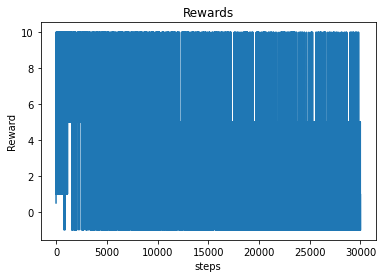

In [ ]:
plt.plot(rew_arr)
plt.xlabel('steps')
plt.ylabel('Reward')
plt.title('Rewards')

In [16]:
point_five = list(rew_arr==0.5).count(True)
rew_one = list(rew_arr==-1).count(True)
rew_ten = list(rew_arr==10).count(True)
rew_five = list(rew_arr==5).count(True)
rew_neg = list(rew_arr==-1).count(True)

Text(0.5, 1.0, 'Rewards')

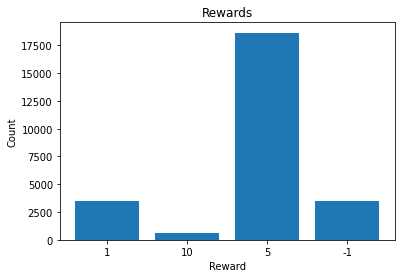

In [17]:
x = ['1','10','5','-1']
y = [rew_one, rew_ten, rew_five, rew_neg]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards')

Text(0.5, 1.0, 'Rewards')

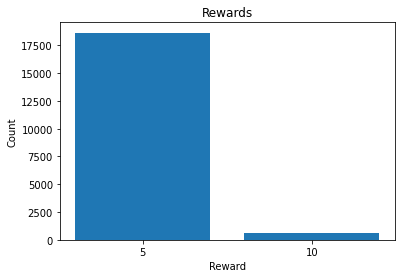

In [18]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards')

In [ ]:
rew_ten

43

Text(0.5, 1.0, 'Rewards for component 0')

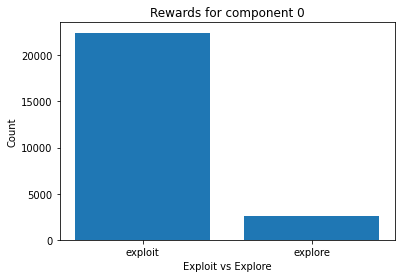

In [19]:
x = ['exploit','explore']
y = [best_cnt, random_cnt]
plt.bar(x,y)
plt.xlabel('Exploit vs Explore')
plt.ylabel('Count')
plt.title('Rewards for component 0')

In [ ]:
obj_arr[:,0]

array([47.66837974, 23.74933794, 47.66837974, ..., 34.48382694,
       31.39599387, 31.39599387])

Text(0.5, 1.0, 'Average Distance between components Obj 1')

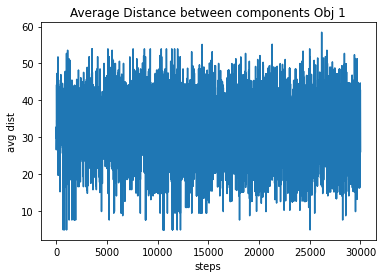

In [ ]:
plt.plot(obj_arr[:,0])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components Obj 1')

Text(0.5, 1.0, 'Average Distance between components Obj 2')

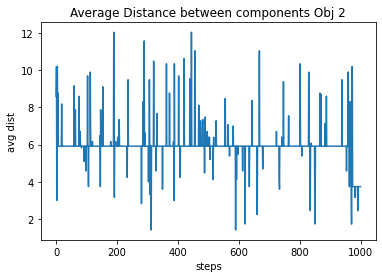

In [ ]:
plt.plot(obj_arr[:,1])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components Obj 2')

In [ ]:
v = np.array(env.env_front_1)
#env.env_front_1[0,:]
v[0,:]

array([ 5.04829097, 10.19803903,  5.74456265,  4.12310563,  1.41421356,
        7.54983444])

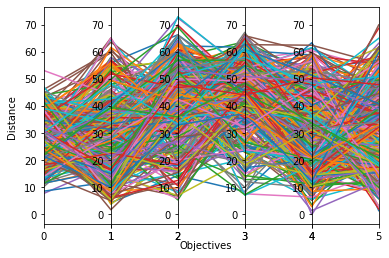

In [20]:
v = np.array(env.env_front_1)
# create data
x = np.arange(0,6) #OBJECTIVE INDEX
#print(x)
#data = [x,x*2,x*x,np.sqrt(x),-x*x,np.sin(x),np.cos(x)]
#print(data)
  
# make subplots
fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, sharey=False)
ax = (ax0,ax1,ax2,ax3,ax4)
fig.text(0.5, 0.04, 'Objectives', ha='center')
fig.text(0.04, 0.5, 'Distance', va='center', rotation='vertical')

# plot subplots and set xlimit
for i in range(5):
    for j in range(len(v)):
        ax[i].plot(v[j,:])
        
    ax[i].set_xlim([x[i],x[i+1]])
    ax[i].set_xticks([x[i],x[i+1]])

# set width space to zero
plt.subplots_adjust(wspace=0)
#plt.xticks([1,2,3,4,5])
# show plot
plt.show()

28.58766583814162
38.92300091205713


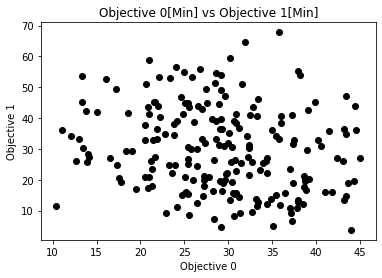

In [ ]:
a=[]

for i in range(len(env.env_front_1)):
  x = env.env_front_1[i][0]
  
  y = env.env_front_1[i][1]
  plt.scatter(x,y,c='black')

'''
for i in range(len(front_val[1])):
  x = front_val[1][i][0]
  y = front_val[1][i][1]
  plt.scatter(x,y,c='blue')'''
plt.title('Objective 0[Min] vs Objective 1[Min]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
#plt.axis([max(x),min(x),max(y),min(y)])
print(x)
print(y)

6.138524034796525
21.77154105707724


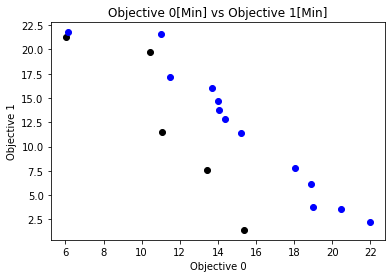

In [ ]:
a=[]

for i in range(len(env.env_front_1)):
  x = env.env_front_1[i][0]
  
  y = env.env_front_1[i][1]
  plt.scatter(x,y,c='black')


for i in range(len(env.env_front_2)):
  x =env.env_front_2[i][0]
  y = env.env_front_2[i][1]
  plt.scatter(x,y,c='blue')
plt.title('Objective 0[Min] vs Objective 1[Min]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
#plt.axis([max(x),min(x),max(y),min(y)])
print(x)
print(y)